## This Notebook plots networks of enriched terms within our screens

In [1]:
import pandas as pd
import numpy as np
import mygene
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import os
#go enrichment analysis tools
from goatools.obo_parser import GODag
from goatools import obo_parser
from goatools.base import download_ncbi_associations
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.gosubdag.gosubdag import GoSubDag

import Plate_Shuffling as ps
import Colony_Analysis as ca

In [2]:
#parse GO stuff
gene2go_fname = download_ncbi_associations()
objanno = Gene2GoReader(gene2go_fname ,taxids=[559292])#, evidence_set='IGI')  # Read data (only for Saccharomyces cerevisiae S288C)
ns2assoc = objanno.get_ns2assc()

#'gene2go.obo' was downloaded from http://current.geneontology.org/ontology/go-basic.obo on the 15.10.21 at 2:30pm
#'go.obo' was downloaded from  http://current.geneontology.org/ontology/go.obo on the 23.11.21 at 10:00am

# we use the optional_attrs option to load 'part_of' relationships, see:
#https://github.com/tanghaibao/goatools/blob/main/notebooks/get_isa_and_partof.ipynb
obo = obo_parser.GODag('go.obo', optional_attrs={'relationship'})


  EXISTS: gene2go
HMS:0:00:03.289298  94,738 annotations,  6,418 genes,  6,059 GOs, 1 taxids READ: gene2go 
go.obo: fmt(1.2) rel(2021-10-26) 47,197 GO Terms; optional_attrs(relationship)


### Parse  Data

In [4]:
#We have pooled unprocessed data from 3 screens and run the filtering on the pooled dataframe
#we load the pooled and processed dataset
Plate_Data  = pd.read_csv('GA1_2_4_6.csv', sep=',')
#GA1_2_4.csv
#gene names are not currently in the 'Entrez' format. Here we convert them to Entrez to match Goatools requirements
## fetch gene name conversion ################################################
mg = mygene.MyGeneInfo()
#create 
geneORFs = list(Plate_Data["gene"])

ID_list  = mg.querymany(geneORFs, scopes='all', fields='entrezgene', species=559292)  # S. cerevisiae S288C
not_found=[]
gene2entrez ={} # a dictionary storing gene name conversion
entrez2gene ={}


for D in ID_list:
    if 'entrezgene' in D.keys(): #check that a uniprot ID was found
        entrez2gene[D[ 'entrezgene']] =D['query']
    else:
        not_found.append(D['query'])

print(len(not_found ),'ID were not found for: ', not_found )

gene2entrez ={}
#manually add wild type with made up Entrez
gene2entrez['WT']='000000'
entrez2gene['000000']='WT'
for D in ID_list:
    if 'entrezgene' in D.keys(): #check that a uniprot ID was found
        gene2entrez[D['query']]=  D[ 'entrezgene']
        
        
#convert the gene names in our data to Entrez ID ################################################
num_del=0
population=[]
for i in range(len(Plate_Data)):
    gene = Plate_Data.loc[i, 'gene']
    if gene in list(gene2entrez.keys()): #makes sure that ID is in gene2entrez
        Plate_Data.loc[i, 'gene'] = gene2entrez[gene]
        population.append(int(gene2entrez[gene]))
    else: 
        Plate_Data = Plate_Data.drop([i])
        num_del+=1
print(num_del ,'genes were deleted because their name didnt find an Entrez ID' )

#some gene might map to the same Entrez gene, we remove the first occurence of duplicated genes
Plate_Data=Plate_Data[Plate_Data['gene'].duplicated() ==False]
  

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4788...done.
Finished.
506 input query terms found dup hits:
	[('0', 4), ('AAC1', 2), ('AAD3', 2), ('AAD4', 2), ('AAD6', 2), ('AAP1', 2), ('ADH5', 2), ('AHT1', 2)
19 input query terms found no hit:
	['ADE5,7', 'DUR1,2', 'WT', 'YAL043C-a', 'YAL058C-A', 'YAR037W', 'YAR040C', 'YAR043C', 'YCL006C', 'YC
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
789 ID were not found for:  ['AAC1', 'AAD3', 'AAD4', 'AAD6', 'ADE5,7', 'AHT1', 'AIM10', 'AIM9', 'ALG3', 'ALT2', 'AMA1', 'API2', 'APL2', 'APM2', 'APQ13', 'ARG5,6', 'ARG81', 'ARN2', 'ARO9', 'ASI1', 'ATG16', 'ATP1', 'ATP14', 'ATP23', 'ATS1', 'AVT3', 'AZF1', 'BBC1', 'BDF1', 'BDF2', 'BNA5', 'BRP1', 'BUD19', 'BUD26', 'BUD28', 'BUD30', 'BUD31', 'BUD7', 'CAF20', 'CAR2', 'CBP4', 'CCC2', 'CMP2', 'COA1', 'COQ2', 'COX20', 'COX5A', 'COX5B', 'CPR6', 'CRN1', 'CTI6', 'CTS1', 'CTS2', 'CUE5', 'CUP2', 'CYC1', '

351 genes were deleted because their name didnt find an Entrez ID


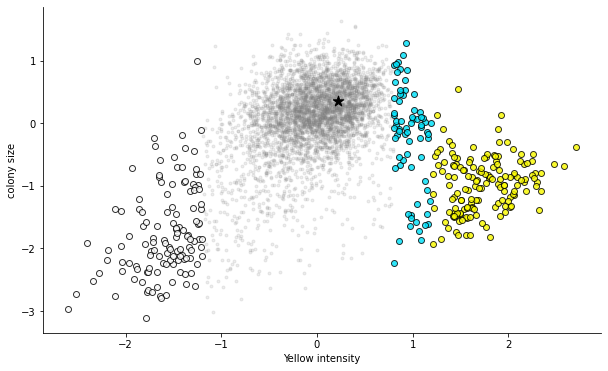

In [5]:
#Plot Yellow vs Fitness Plot (Figure 5)

metricY= 'corrected_area.24_mean' 
metricX= 'corrected_mean_intensity.24_mean' 
Bottom_color=[1,1,1]
Middle_color=[0.5,0.5,0.5]
Top_color=[1,1,0]


i_nan = (Plate_Data[metricX ].isna() == 0) & (Plate_Data[metricY ].isna() == 0)
fig, axs= plt.subplots( figsize=(10,6))

#plot all genes we have data for:
axs.scatter(Plate_Data[metricX],Plate_Data[ metricY] , alpha=0.14, color=Middle_color, marker='.' )

#Highlight the most yellow cluster:
yellow_gate = pd.Interval(left=1.2, right=4)
i_sort=np.array([x in yellow_gate  for x in Plate_Data[i_nan][metricX ]])
group_top = set(Plate_Data[i_nan]['gene'].iloc[i_sort].values.astype(int))
i_select = Plate_Data['gene'].isin([str(g) for g in group_top])
axs.scatter(Plate_Data[metricX][i_select],Plate_Data[ metricY][i_select],color=Top_color, alpha=0.8,edgecolors=[0,0,0] )

#hightlight the second most yellow group, the cyan group
yellow_gate = pd.Interval(left=0.8, right=1.2)
gate1=np.array([x in yellow_gate  for x in Plate_Data[i_nan][metricX ]])
i_sort = gate1
group_fit = set(Plate_Data[i_nan]['gene'].iloc[i_sort].values.astype(int))


i_select = Plate_Data['gene'].isin([str(g) for g in group_fit])
axs.scatter(Plate_Data[metricX][i_select],Plate_Data[ metricY][i_select], facecolor=[0,0.9,1], alpha=0.8,edgecolor=[0,0,0])
#axs.scatter(Plate_Data[metricX][i_select],Plate_Data[ metricY][i_select], color=[0,0.8,0.8], alpha=0.1 )


#highlights the white hist

yellow_gate = pd.Interval(left=-5, right=-1.2) #(left=0, right=2.5)
i_sort=np.array([x in yellow_gate  for x in Plate_Data[i_nan][metricX ]])
group_bottom = list(Plate_Data[i_nan]['gene'].iloc[i_sort].values.astype(int))
i_select = Plate_Data['gene'].isin([str(g) for g in group_bottom])

axs.scatter(Plate_Data[metricX][i_select],Plate_Data[metricY][i_select],color=Bottom_color, alpha=0.8,edgecolors=[0,0,0] )




#label WT:
i_select = Plate_Data['gene'].isin([str(g) for g in ['000000']])
plt.scatter(Plate_Data[metricX][i_select],Plate_Data[metricY][i_select],color=[0,0,0], alpha=1,s=120, marker='*' )



axs.set_xlabel('Yellow intensity')
axs.set_ylabel('colony size')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
plt.show()




## Run Go Terms Enrichment Analysis

In [8]:
#place terms in a list:

################################
#redefine population to include only non NaN genes for metric
population =list(Plate_Data[i_nan]['gene'].values.astype(int))
#from Benjamin:
# Over-representation object:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
goeaobj = GOEnrichmentStudyNS(
    population,  # Population (all mapped yeast genes in Entrez format)
    ns2assoc,  # geneid/GO associations
    obo,  # Ontologies
    propagate_counts = False,  # ???
    alpha = 0.05,  # default significance cut-off
    methods = ['fdr_bh'])  # default multipletest correction method
################################

def return_GEA(gene_group):
    '''Return a DF with the GO terms which p-values are below 0.05 
    also returns those terms as a set (go_set)'''
    goea_results_all = goeaobj.run_study(gene_group, prt=None)
    top=0
    GOs=[]
    for term in goea_results_all:
        if term.p_fdr_bh <1:
            top+=1
        if term.p_fdr_bh <0.05: #if term.p_uncorrected <0.05:#
            top+=1
            GOs.append([term.GO,term.name, term.p_fdr_bh])

    GOs=pd.DataFrame(GOs, columns =('go','description','p'))
    GEA= GOs.iloc[GOs['p'].argsort()]

    go_set=GEA['go'].values
    GEA=GEA.drop_duplicates()
    #for some reason some terms are duplicated, we keep the first occurence
    i2keep = GEA['go'].duplicated(keep='first')==False
    GEA=GEA[i2keep ]

    return GEA,  go_set



Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 88%  3,691 of  4,210 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 94%  3,942 of  4,210 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 76%  3,193 of  4,210 population items found in association


In [9]:
#Print Terms found to be enriched for Yellow guys
GEA_top ,go_set_top = return_GEA(group_top)
GEA_top

,go,description,p
18,GO:0005739,mitochondrion,7.070308e-69
0,GO:0032543,mitochondrial translation,2.635923e-48
19,GO:0005762,mitochondrial large ribosomal subunit,2.247716e-33
20,GO:0005743,mitochondrial inner membrane,2.046030e-27
21,GO:0005840,ribosome,9.372719e-21
39,GO:0003735,structural constituent of ribosome,2.739798e-20
1,GO:0006412,translation,1.049706e-18
2,GO:0033617,mitochondrial cytochrome c oxidase assembly,1.127021e-13
22,GO:0031314,extrinsic component of mitochondrial inner mem...,6.583998e-13
34,GO:0005737,cytoplasm,3.205708e-12


In [10]:
#Print Go Terms found to be enriched for White guys
GEA_bottom,go_set_bottom = return_GEA(group_bottom)
GEA_bottom

,go,description,p
0,GO:0002181,cytoplasmic translation,9.318485e-07
1,GO:0007035,vacuolar acidification,7.356589e-06
18,GO:0005840,ribosome,2.835363e-05
2,GO:0006412,translation,4.703125e-05
26,GO:0003735,structural constituent of ribosome,1.273373e-04
27,GO:0046961,"proton-transporting ATPase activity, rotationa...",1.273373e-04
19,GO:0022627,cytosolic small ribosomal subunit,2.419713e-04
3,GO:0006364,rRNA processing,3.512158e-04
20,GO:0000781,"chromosome, telomeric region",5.538810e-04
4,GO:1904669,ATP export,1.571845e-03


In [11]:
#print enriched terms for blue guys (none are found):

GEA_fit,go_set_bfit= return_GEA(group_fit)
GEA_fit

,go,description,p


## Draw Networks

In [ ]:
# We draw a networks where nodes are GO terms we found significantly enriched in a gene group
# The edges of the networks represent the number of genes (in our gene group) shared between GO terms. 
#The data of our network is stored in a dictionary called Onto (Ontology)
#Onto is dict where keys are parent terms and values are a lists storing:
#0: a set of children terms, 1: a list genes associated with the parent term:
    

In [12]:
def find_parent(term, Onto):
    '''Find parents for orphan terms in Onto'''
    parents=[]
    for go, [kids,genes] in Onto.items():
        if term in kids:
            parents.append(go)
    return parents


def Onto_gene2go(gene_group, go_set ):
    '''create the Onto dictionary'''
    gene_list =[]
    for group in [gene_group]:
        [gene_list.append(gene) for gene in group  ]

    #we create a dictionary linking each gene in our gene group to an associated go term
    gene2go={}
    #prepare the dictionary:
    for gene in gene_list:
        gene2go[gene]=set()

    #here we loop trough ns2assoc, we add the genes that are in gene list and the gos which are in go_set
    for T in ns2assoc.items():
        for gene, GOs in T[1].items():
            if gene in gene_list:
                [gene2go[gene].add(go) for go in GOs if go in go_set]
    
    #we redefine go_set, now it stores all the terms in gene2go (it might get smaller if an enriched term was not associate with any gene) )
    #list all GOs once
    go_set=[]
    for GOs in gene2go.values():
        [go_set.append(go) for go in GOs]
    #add the 3 top roots to go_set
    [go_set.append(go) for go in ['GO:0005575','GO:0003674','GO:0008150' ]]
    go_set=set(go_set)
    
    #We create a Mirror Dictionary storing {GO: [genes]}
    go2gene={}
    #prepare the dictionary:
    for go in go_set:
        go2gene[go]=[]
    #fill dict:
    for gene, GOs in gene2go.items():
        for go in GOs:
            if gene not in go2gene[go]:
                go2gene[go].append(gene)

    ### Create our ontology: Onto
    
    #some term in obo might not be present in ns2assoc and vice versa. 
    #we take obo U ns2assoc (terms and genes might be left out if not in obo)
    Onto={} #stores the onto graph with two lists: the children terms and the associated genes
    for ID, go in obo.items():
        if ID in go_set:
            kids=set([kid.id for kid in go.children]) #all kids found in obo
            #needs filtering:
            Onto[ID]=[set.intersection(kids, go_set) , go2gene[ID] if ID in go2gene else [] ]

    #here we extract the  relationships 'part_of'.
    #if a term1 is 'part_of' or 'occurs_in' another parent term2 we add term1 to the kids of term2 
    for ID, go in obo.items():
        if ID in go_set:
            #find if term has is part_of relationship:
            other_relationships = [R for R in go.relationship if (R == 'part_of' )or  (R == 'occurs_in')]
            kins=[] 
            for R in other_relationships:
                kins = [kin.id for kin in go.relationship[R]]#terms to which the go is part of
            #check that the kins are in go_set
            kins = set.intersection(set(kins), go_set) 
            #add term to its parental kins
            for kin in kins:
                Onto[kin][0].add(ID)

    #create the global root linking the three branches of the Ontology
    Onto['global_root']=[set(['GO:0005575','GO:0003674','GO:0008150' ]),[]]

    #add ['GO:0005575','GO:0003674','GO:0008150' ] if not in Onto:
    for GO in ['GO:0005575','GO:0003674','GO:0008150' ]:
        if GO not in list(Onto.keys()):
            Onto[GO]=[set(), list()]


    #some terms will be added to Onto eventhough there parents are not (not in go_set).
    #those orphan terms need to be connected
    #find the orphans:
    orphans=set()
    for term in tqdm(Onto.keys()):
        if len(find_parent(term, Onto))==0:
            orphans.add(term)
    #do not count 'global_root as an orphan
    orphans = orphans - {'global_root'}
    print('nr of orphans:',len(orphans))

    #connect the orphans:
    not_orphan=set()
    for orphan in tqdm(orphans):

        ancestors = GoSubDag([orphan], obo, prt=None) #find ancestors of orphan term
        ancestors = ancestors.rcntobj.go2ancestors[orphan]
        for ancestor in ancestors:
            if ancestor in go_set:
                Onto[ancestor][0].add(orphan)
                not_orphan.add(orphan)

    print(len(not_orphan) ,'/', len(orphans), 'orphans were found parents')
    
    return Onto, gene2go



Onto_top, gene2go_top= Onto_gene2go(group_top, go_set_top)

Onto_bottom, gene2go_bottom= Onto_gene2go(group_bottom, go_set_bottom)


  3%|▎         | 1/31 [00:00<00:05,  5.82it/s]

nr of orphans: 31


100%|██████████| 31/31 [00:03<00:00,  8.97it/s]


31 / 31 orphans were found parents


  0%|          | 0/25 [00:00<?, ?it/s]

nr of orphans: 25


100%|██████████| 25/25 [00:04<00:00,  5.73it/s]

25 / 25 orphans were found parents


## Draws network with NetworkX and Cytoscape

In [13]:
### Connect to cytoscape
#check https://py4cytoscape.readthedocs.io/en/latest/tutorials/Overview-of-py4cytoscape.html
import py4cytoscape as p4c

p4c.cytoscape_ping()
p4c.cytoscape_version_info()

You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.0',
 'automationAPIVersion': '1.3.0',
 'py4cytoscapeVersion': '0.0.11'}

In [14]:
def term_through_gene( gene2go, term='' ,graph=nx.DiGraph()):
    '''Creates a Graph linking GO terms through there common genes'''

    #we link Terms through their common genes
    for gene, IDs in gene2go.items():
        [graph.add_node(ID) for ID in IDs]
        #find all pairs in IDs:
        pairs = pairwise_combine(list(IDs))

        for pair in pairs:
            graph.add_edge(pair[0],pair[1])

    return graph

def pairwise_combine(Items):
    '''Return an array combining all items pairs (items dont repeat within pairs)'''
    Items = np.array(Items)
    Items = np.meshgrid(Items,Items) #create all possible pairs
    Items = np.stack(np.tril(Items),axis=2) #set to '' the upper triangle of the matrix
    Items = np.unique(Items.reshape(-1,2), axis=0) #reshape in a column array, remove repeating pairs (including ['','']) 
    Items = Items[Items[:,0]!=Items[:,1],:] #Removes pairs where terms are the same: ['item1', 'item1']
    return Items

def color_node2(term, Onto, obo=obo):
    '''allocates a function group to a node based on user defined words'''
    #find all parents names:
    ancestors = leach_ancestry(term, ancestry=set())

    ancestors = set([obo[A].name for A  in ancestors])
    # add the go term to its ancestor 
    ancestors.add(obo[term].name)

    color ='grey' #grey is the default color
    cell_part = 'undefined'
    
    if any([('mitochondr' in a)
            or ('respira' in a)
            or ('ubiquin' in a) for a in ancestors]) : #check if mitochondr is part of ancestors name
        color = 'red'
        cell_part = 'mitochondrion'
    elif any([('translation' in a) 
        or ('RNA' in a)
        or ('nucleolus' in a)
        or ('ribosome' in a)for a in ancestors]):
        color = 'blue'
        cell_part = 'translation'
        
    elif any([('endosome' in a)
              or ( 'vacuol' in a)
              or ( 'multivesicul' in a)
              or ( 'ubiquit' in a) for a in ancestors]):
        color = 'green'
        cell_part = 'protein trafficking/degradation'
    return color, cell_part


# We will draw the different graphs in Cytoscape separately,
# to unify their scales we extract 2 parameters scaling node and edge sizes which will be common to all graphs:

def single_graph_scale(graph, Onto, GEA, bins):
    '''Returns the maximum node and edge of a single graph '''
    max_edge_param=0
    for i, edge in enumerate(graph.edges):
        if (type(edge[0]) != np.int64) & (type(edge[1]) != np.int64) : #terms are not int
            edge_genes = [Onto[E][1] for E in edge]
            
            max_edge_param = max( max_edge_param, len(set(edge_genes[0]).intersection(set(edge_genes[1]))))
    max_node_param=0
    for i, node in enumerate(graph):
        P = GEA[GEA['go']==node]['p'].item()
        S= np.digitize(np.log10(P), bins, right=False)
        max_node_param=max(max_node_param,S)

    return max_node_param,max_edge_param


def all_graph_scale(graph_list, Onto_list, GEA_list, bins):
    '''uses single_graph_scale() iteratively to find the maximum edge/node size of a list of graps
    ! the order in graph_list, Onto_list, GEA_list must be the same!'''
    max_node_param=0
    max_edge_param=0
    for graph, Onto,GEA in zip(graph_list, Onto_list,GEA_list):
        max_node_param = max(max_node_param, single_graph_scale(graph, Onto, GEA, bins)[0])
        max_edge_param = max(max_edge_param, single_graph_scale(graph, Onto, GEA, bins)[1])
    return max_node_param,max_edge_param

def leach_ancestry(term, ancestry=set(), obo=obo):
    '''find all ancestors of a term in obo'''
    #add the traditional parents:
    parents = set([parent.id for parent in obo[term].parents ])
    
    #add parents through relationship part_of and parents
    relationships = [R for R in obo[term].relationship if (R == 'part_of') or R=='occurs_in' ]

    for R in relationships:
        [parents.add(P) for P in [parent.id for parent in obo[term].relationship[R]]]

    for ID in parents:
        ancestry.add(ID)
        leach_ancestry(ID, ancestry)

    return list(ancestry)

def graph_pimp(graph,Onto,GEA, bins,max_node_param,max_edge_param ):
    '''adds Node size/name and  edge size/transparency'''
    for i, edge in enumerate(graph.edges):
        #find the genes in common between two terms:
        edge_genes = [Onto[E][1] for E in edge] #retrieve the genes in the 2 terms
        shared_genes = len(set(edge_genes[0]).intersection(set(edge_genes[1])))
        graph.edges[edge]['weight'] = int(np.log(100*(shared_genes)/(max_edge_param))*6) +2
        graph.edges[edge]['transparency'] = 255*shared_genes/max_edge_param
        graph.edges[edge]['label'] = ''
    
    for i, node in enumerate(graph):
        colour,_=color_node2(node, Onto)
        graph.nodes[node]['colour']= colour
        description =  obo[node].name
        #split the description into 2 lines if it is too long:
        description = description[0:int(len(description)/2)] +'-\n' +description[int(len(description)/2):]  if len(description)>20 else description

        graph.nodes[node]['label']= description if len(description) < 50 else  node #[node if 'mito' in obo[node].name else ' '][0]
        #term enrichment significance
        P = GEA[GEA['go']==node]['p'].item()
        #node size based on pvalue of GO
        S= np.digitize(np.log10(P), bins, right=False) #digitize returns the bin number to which p belong
        graph.nodes[node]['size']=int(np.log(100*(S-2)/(max_node_param-2))*6)#25*(np.log(S)-2)/(max_node_param-2)+5
    
    return graph



In [15]:
##Draw a network where GO terms are nodes linked through their common genes
G_top = term_through_gene(gene2go_top, graph=nx.DiGraph())
G_bottom = term_through_gene(gene2go_bottom , graph=nx.DiGraph())


# to make sure scale is consistent when plotting several graphs on the same figure we extract soem size paramaters:
bins=np.arange(-66,2)[::-1] #list of x for binning p-values 10^(-x)
#extract scaling parameters common to top and bottom graphs 
max_node_param,max_edge_param = all_graph_scale([G_top,G_bottom], [Onto_top,Onto_bottom],[GEA_top,GEA_bottom], bins)


#change the label/size of nodes/ size/transparency of edges
G_top= graph_pimp(G_top,Onto_top,GEA_top,bins,max_node_param,max_edge_param )
G_bottom= graph_pimp(G_bottom,Onto_bottom,GEA_bottom,bins,max_node_param,max_edge_param )



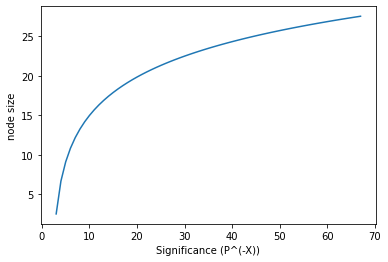

In [16]:
## For all nodes to be visible, we use a none linear scale between significance and node size
## This is the significance node size relationship:
x=np.arange(3,max_node_param)
y=np.log(100*(x-2)/(max_node_param-2))*6
plt.ylabel('node size')
plt.xlabel('Significance (P^(-X))')
plt.plot(x,y)
plt.show()

## Transfer Graph to Cytoscape 

In [17]:
#create pd DF for cytoscape for graph
G= G_top.copy()
Edges_df = nx.to_pandas_edgelist(G)
Edges_df['weight'] = [G.edges[E]['weight'] for E in G.edges]
Edges_df['transparency'] = [G.edges[E]['transparency'] for E in G.edges]
Edges_df['label'] = [G.edges[E]['label'] for E in G.edges]

Nodes_df = pd.DataFrame(data={'id':G.nodes,
                              'colour':[G.nodes[N]['colour'] for N in G.nodes],
                              'size' :[int(G.nodes[N]['size']) for N in G.nodes],
                              'label' :[G.nodes[N]['label'] for N in G.nodes]
                             })
p4c.create_network_from_data_frames(Nodes_df, Edges_df, title="my first network", collection="DataFrame Example")


Applying default style...
Applying preferred layout


{'networkSUID': 4701}

In [18]:
#Set node/edges size and colors
#https://py4cytoscape.readthedocs.io/en/0.0.5/reference/styles.html?highlight=edge#edge-style-mappings
#specify node color:
#p4c.set_node_shape_default('ROUND_RECTANGLE')

fade=40
column = 'colour'
values = ['grey', 'red', 'blue', 'green', 'pink']
colour = ['#%02x%02x%02x'.upper() % (200, 200, 200),
          '#%02x%02x%02x'.upper() % (255, 170, 170),
          '#%02x%02x%02x'.upper() % (170, 170, 255),
          '#%02x%02x%02x'.upper() % (170, 255, 170),
         '#%02x%02x%02x'.upper() % (255, 200, 200)]

p4c.set_node_color_mapping(column, values, colour ,mapping_type='d')


#specify node size:

#p4c.set_node_color_mapping('size', [size_min, size_center, size_max], [1, 5, 9])
sizes=[int(i) for i in np.unique(Nodes_df['size'])]
sizes2=[int(i) for i in np.unique(Nodes_df['size'])] #the list should be in growing order int(i)/3 +20
sizes.sort()
sizes2.sort()
p4c.set_node_size_mapping('size',sizes,sizes2,mapping_type='c')

#specify edge width:

#p4c.set_node_color_mapping('size', [size_min, size_center, size_max], [1, 5, 9])
weight=[int(i) for i in np.unique(Edges_df['weight'])]
weight2=[int(i)/10 for i in np.unique(Edges_df['weight'])] #int(i)*0+4
p4c.set_edge_line_width_mapping('weight',weight,weight2,mapping_type='c')

#specify edge opacity:

#p4c.set_node_color_mapping('size', [size_min, size_center, size_max], [1, 5, 9])
alpha=[int(i) for i in np.unique(Edges_df['transparency'])]
alpha2=[int(i) for i in np.unique(Edges_df['transparency'])]
p4c.set_edge_opacity_mapping('transparency',alpha,alpha2,mapping_type='c')

p4c.set_node_label_mapping('label')
p4c.set_edge_font_size_default(5)
p4c.set_edge_label_mapping('label')
p4c.set_node_font_size_default(8)
p4c.set_node_fill_opacity_default(255)
p4c.set_node_label_opacity_default(255)


style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


''

### Create a layout with NetworkX and transfer positions to Cytoscape

#### top graph 

In [22]:
Onto= Onto_top.copy()

#assign a functional groups to nodes whith a specific color:
functional_groups=['protein trafficking/degradation','mitochondrion','translation', 'undefined']
group2node={}
for group in functional_groups:
        group2node[group]= [N for N in G.nodes if group == color_node2(N, Onto)[1] ]

#create mirror dictionary
node2group={}
for group, nodes in group2node.items():
    for node in nodes:
        node2group[node]=  group

        
# Creates a subgraph for each functional group. Store positions in node_pos
node_pos={}
group_graph={}
for group in functional_groups:
    group_graph[group]= nx.subgraph(G, group2node[group])
    pos = graphviz_layout(group_graph[group], prog='neato') #neato-> Kamada-Kawai algorithm
    #recenter the subgraph
    for go , (x,y) in pos.items():

        node_pos[go] =( x,y)        



# contracts or expands subgraph
for group, nodes in group2node.items():
    for node in nodes:
        (x,y) = node_pos[node]
        #this if statement controls the spread of points in their cluster
        if group == 'mitochondrion':
            x=x*1.5
            y=y*1.5
        elif group == 'undefined':
            x=x*0.8
            y=y*0.8
        elif group == 'translation':
            x=x*1
            y=y*1
        elif group == 'protein trafficking/degradation':
            x=x*1
            y=y*1
        node_pos[node] = (x,y)
        
        
        
#assign center coordinate for each subgraph
group_center={}
#assign center coordinate for each subgraph manually:
group_center['translation']=(+20,-60)
group_center['mitochondrion']=(-400,-120)
group_center['protein trafficking/degradation']=(120, 200)
group_center['undefined']=(-100,162)


# relocate subgrpah for each functional group.

for node, group in  node2group.items():
        node_pos[node] =(  node_pos[node][0]+group_center[group][0], node_pos[node][1]+group_center[group][1])
   
#apply modifications to graph;

for node, group in  node2group.items():
        p4c.set_node_property_bypass(node,node_pos[node][0],'NODE_X_LOCATION')    
        p4c.set_node_property_bypass(node,node_pos[node][1],'NODE_Y_LOCATION')


#### Manually relocate some nodes for visibility

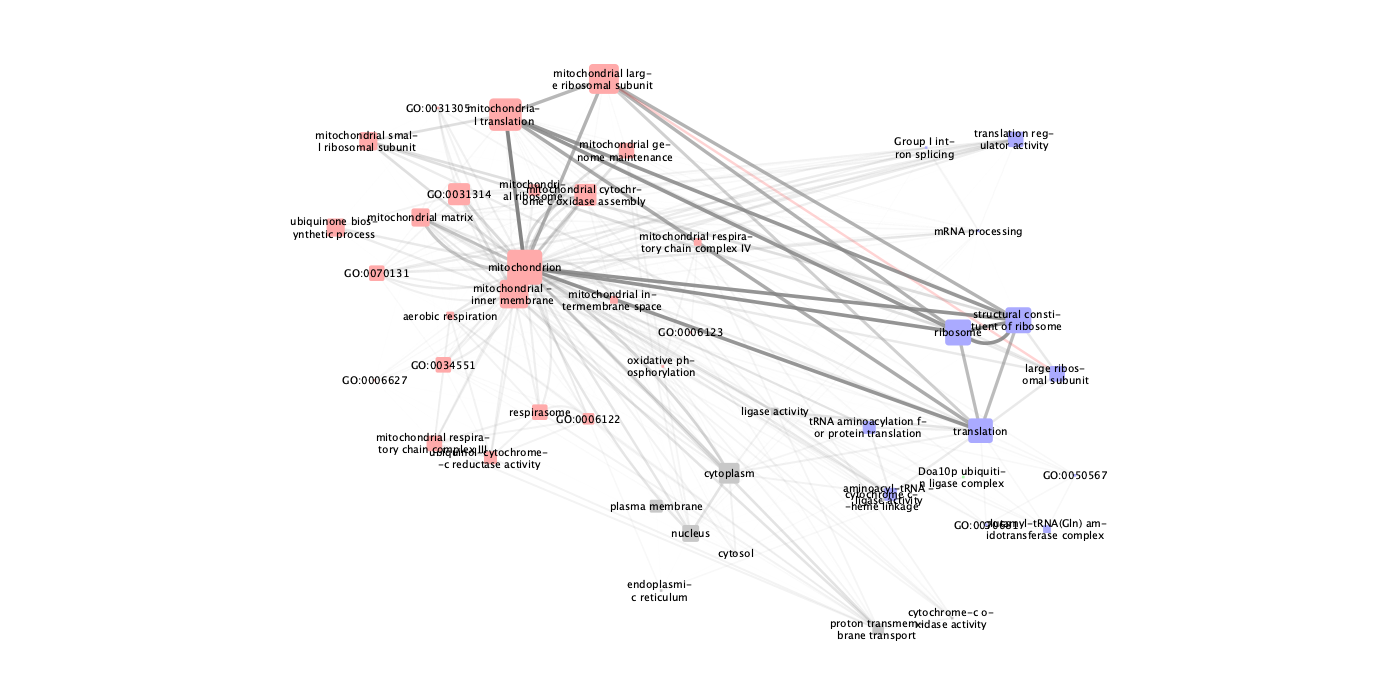

In [23]:
#show graph
p4c.notebook_export_show_image()

## Draw the scale

In [66]:


max_node_param,max_edge_param = max_node_param,max_edge_param = all_graph_scale([G_top,G_bottom], [Onto_top,Onto_bottom],[GEA_top,GEA_bottom], bins)

In [67]:
#dont run
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

legend = nx.DiGraph()
#adds legends to graph
exponents= list(np.linspace(3,max_node_param,6).astype(int))
#exponents.append(-3)
#exponents.append(-4)
#exponents.append(-5)
exponents =[3,6,12, 24, 48, 68]
for i,e  in enumerate(exponents):
    


    legend.add_node(str(e))
    legend.nodes[str(e)]['size']= int(np.log(100*(e-2)/(max_node_param-2))*6)
    #int(50*e/max_node_param)
    node_name= 'P= '+str(10)+get_super('-')+get_super(str(e))
    legend.nodes[str(e)]['label'] =node_name
    legend.nodes[str(e)]['colour']= 'grey'

shared_genes = max_edge_param-np.quantile(range(max_edge_param),[0.25,0.50,0.75]).astype(int)[::-1]
e1=str(exponents[0])
e2=str(exponents[1])


legend.add_edge(e1,e2)
legend.edges[(e1,e2)]['weight'] = int(np.log(100*(shared_genes[0])/(max_edge_param))*6) +2#shared_genes[0]
legend.edges[(e1,e2)]['transparency'] = 255*shared_genes[0]/max_edge_param
legend.edges[(e1,e2)]['label'] = str(shared_genes[0]) + ' Shared Genes'


e1=str(exponents[2])
e2=str(exponents[3])

legend.add_edge(e1,e2) 
legend.edges[(e1,e2)]['weight'] = int(np.log(100*(shared_genes[1])/(max_edge_param))*6) +2 #shared_genes[1]
legend.edges[(e1,e2)]['transparency'] = 255*shared_genes[1]/max_edge_param
legend.edges[(e1,e2)]['label'] =  str(shared_genes[1]) + ' Shared Genes'

e1=str(exponents[4])
e2=str(exponents[5])

legend.add_edge(e1,e2) 
legend.edges[(e1,e2)]['weight'] = int(np.log(100*(shared_genes[2])/(max_edge_param))*6) +2
legend.edges[(e1,e2)]['transparency'] = 255*shared_genes[2]/max_edge_param
legend.edges[(e1,e2)]['label'] = str(shared_genes[2]) + ' Shared Genes'

   
#create pd DF for cytoscape for legend

Edges_df = nx.to_pandas_edgelist(legend)
Edges_df['weight'] = [legend.edges[E]['weight'] for E in legend.edges]
Edges_df['transparency'] = [legend.edges[E]['transparency'] for E in legend.edges]
Edges_df['label'] = [legend.edges[E]['label'] for E in legend.edges]

Nodes_df = pd.DataFrame(data={'id':legend.nodes,
                              'size' :[int(legend.nodes[N]['size']) for N in legend.nodes],
                              'label' :[legend.nodes[N]['label'] for N in legend.nodes]
                             })


p4c.create_network_from_data_frames(Nodes_df, Edges_df, title="my first network", collection="DataFrame Example")
p4c.set_node_color_default('#%02x%02x%02x'.upper() % (200, 200, 200))
p4c.set_node_font_size_default(8)
p4c.set_edge_font_size_default(8)

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


''

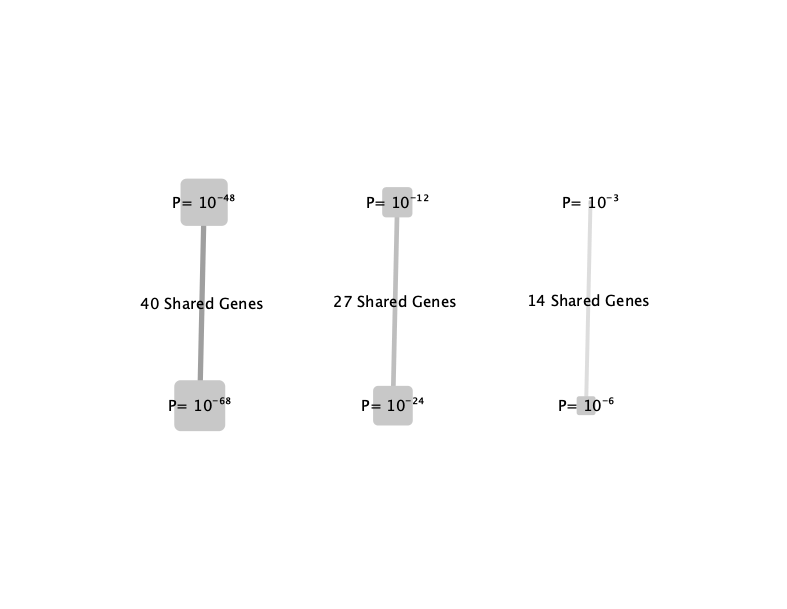

In [68]:
#show graph
p4c.notebook_export_show_image()